In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


## Table Of Contents

1. Meeting Our Data

In [2]:
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 8.1 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor,AdaBoostClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from feature_engine.outliers import Winsorizer

# 1. Meeting Our Data

In [4]:
train=pd.read_csv('../input/playground-series-s3e16/train.csv')
test=pd.read_csv('../input/playground-series-s3e16/test.csv')

# set seed for reproducibility
seed = np.random.seed(0)

In [5]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [6]:
# Explore the Data Types
train.dtypes.unique

<bound method Series.unique of id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object>

In [7]:
#Numeric Data
train.select_dtypes(exclude = 'object').describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


Observation:

Height cannot be 0.

In [8]:
# Is it the same for Test also?

test.select_dtypes(exclude = 'object').describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,14251.458382,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,74051.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


In [9]:
#Categorical Data
train.select_dtypes(include = 'object').describe()

,Sex
count,74051
unique,3
top,M
freq,27084


In [10]:
#Let's look at our target variable 

train['Age'].describe()

count    74051.000000
mean         9.967806
std          3.175189
min          1.000000
25%          8.000000
50%         10.000000
75%         11.000000
max         29.000000
Name: Age, dtype: float64

In [11]:
#Making sure Age column doesn't have NULLS or we drop them.

train['Age'].isna().sum()

0

# 2. Visualisation and EDA

In [12]:
# Setting up Seaborn library
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from scipy import stats

In [13]:
def plot_grid(data, fig_size, grid_size, plot_type, target = '',bins=10):
    """
    Custom function for plotting grid of plots.
    It takes: DataFrame of data, size of a grid, type of plots, string name of target variable;
    And it outputs: grid of plots.
    """
    fig = plt.figure(figsize = fig_size)
    if plot_type == 'histplot':
        for i, column_name in enumerate(data.select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.histplot(data[column_name], kde = True, color = 'red', stat = 'count', bins=bins)
            plot.set_xlabel(column_name, fontsize = 16)           
    if plot_type == 'boxplot':
        for i, column_name in enumerate(data.select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.boxplot(x = data[column_name], color = 'red')
            plot.set_xlabel(column_name, fontsize = 16)
    if plot_type == 'scatterplot':
        for i, column_name in enumerate(data.drop(target, axis = 1).select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.scatterplot(x = data[column_name], y = data[target], color = 'red')
            plot.set_xlabel(column_name, fontsize = 16)
    if plot_type == 'boxplot_cat':
        for i, column_name in enumerate(data.select_dtypes(include = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            sort = data.groupby([column_name])[target].median().sort_values(ascending = False) # This is here to make sure boxes are sorted by median
            plot = sns.boxplot(x = data[column_name], y = data[target], order = sort.index, palette = 'Reds')
            plot.set_xlabel(column_name, fontsize = 16)
    if plot_type == 'barplot_cat':
        for i, column_name in enumerate(data.select_dtypes(include = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.barplot(x = data[column_name], y = data[target], palette = 'Reds')
            plot.set_xlabel(column_name, fontsize = 16)
    plt.tight_layout()

## 2.1 Target Variable

Text(0.5, 0, 'Age')

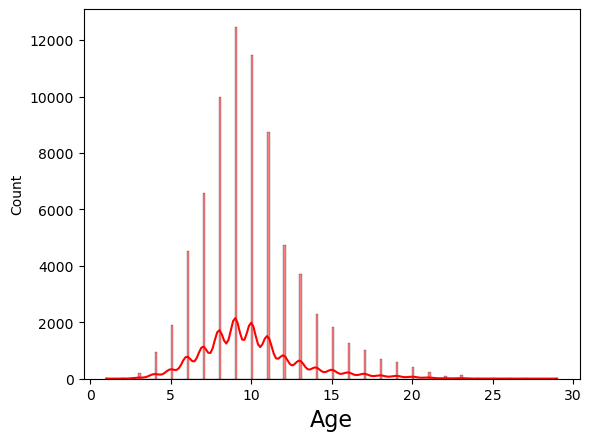

In [14]:
# Let's look at the distribution of target variable
target=train['Age'].copy()

plot = sns.histplot(train['Age'], kde = True, color = 'red', stat = 'count')
plot.set_xlabel('Age', fontsize = 16)

## 2.2 Numerical Features

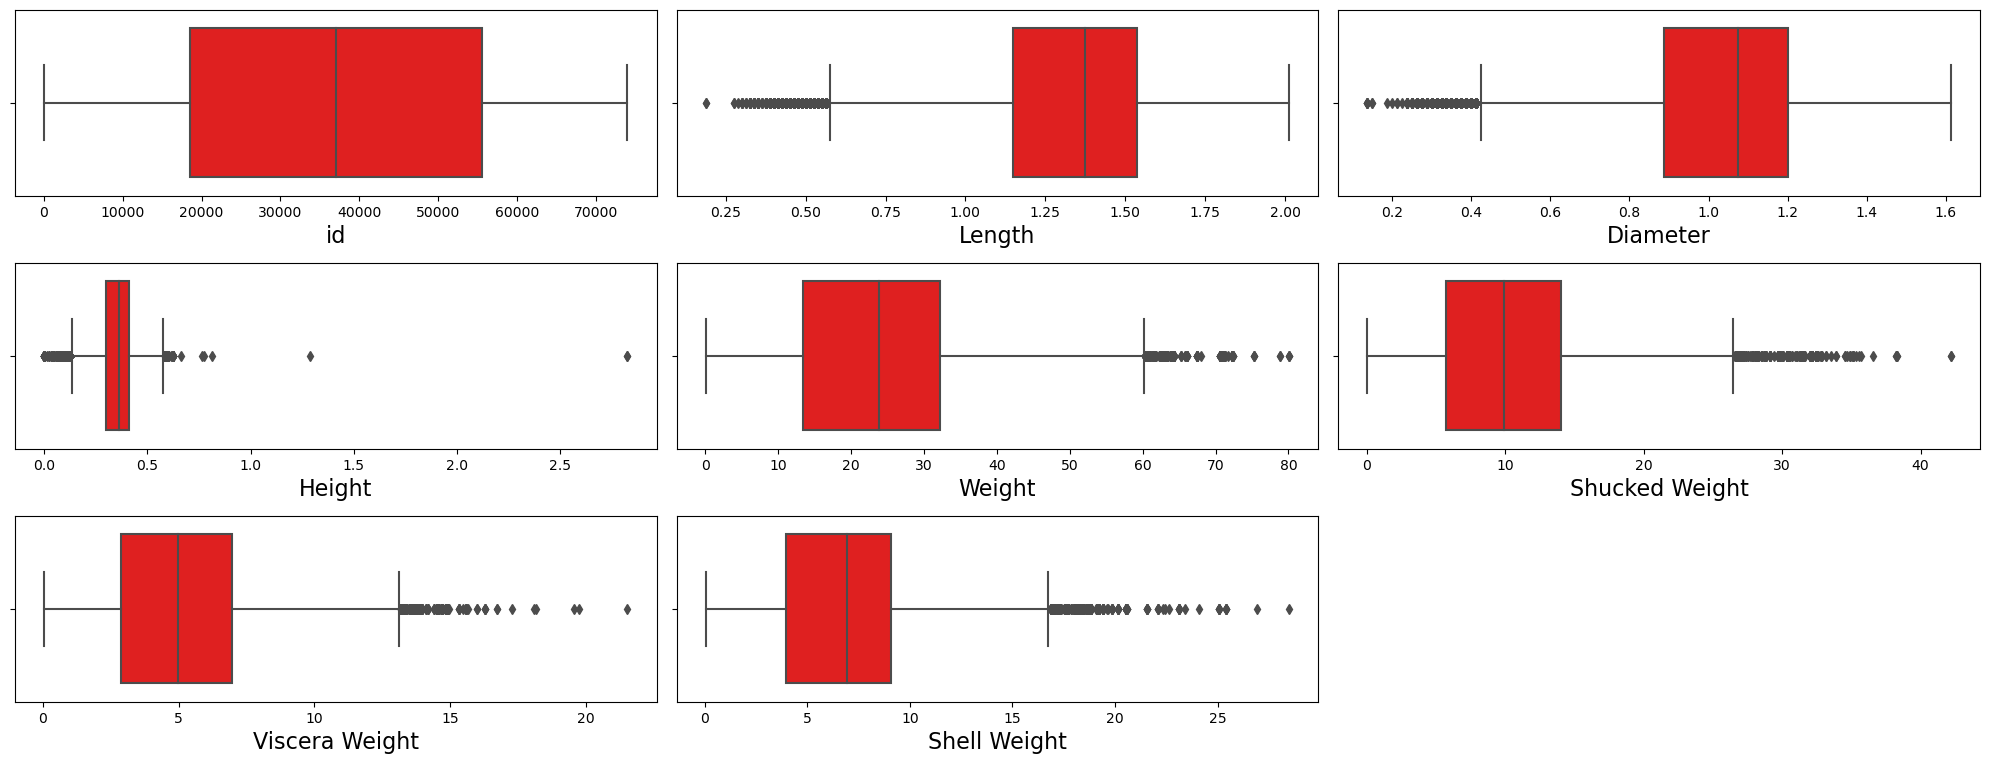

In [15]:
#Let's try some boxplot for our numerical features

plot_grid(train.drop('Age',axis=1),
          fig_size=(20,30), grid_size=(12,3), plot_type='boxplot', target='Age')

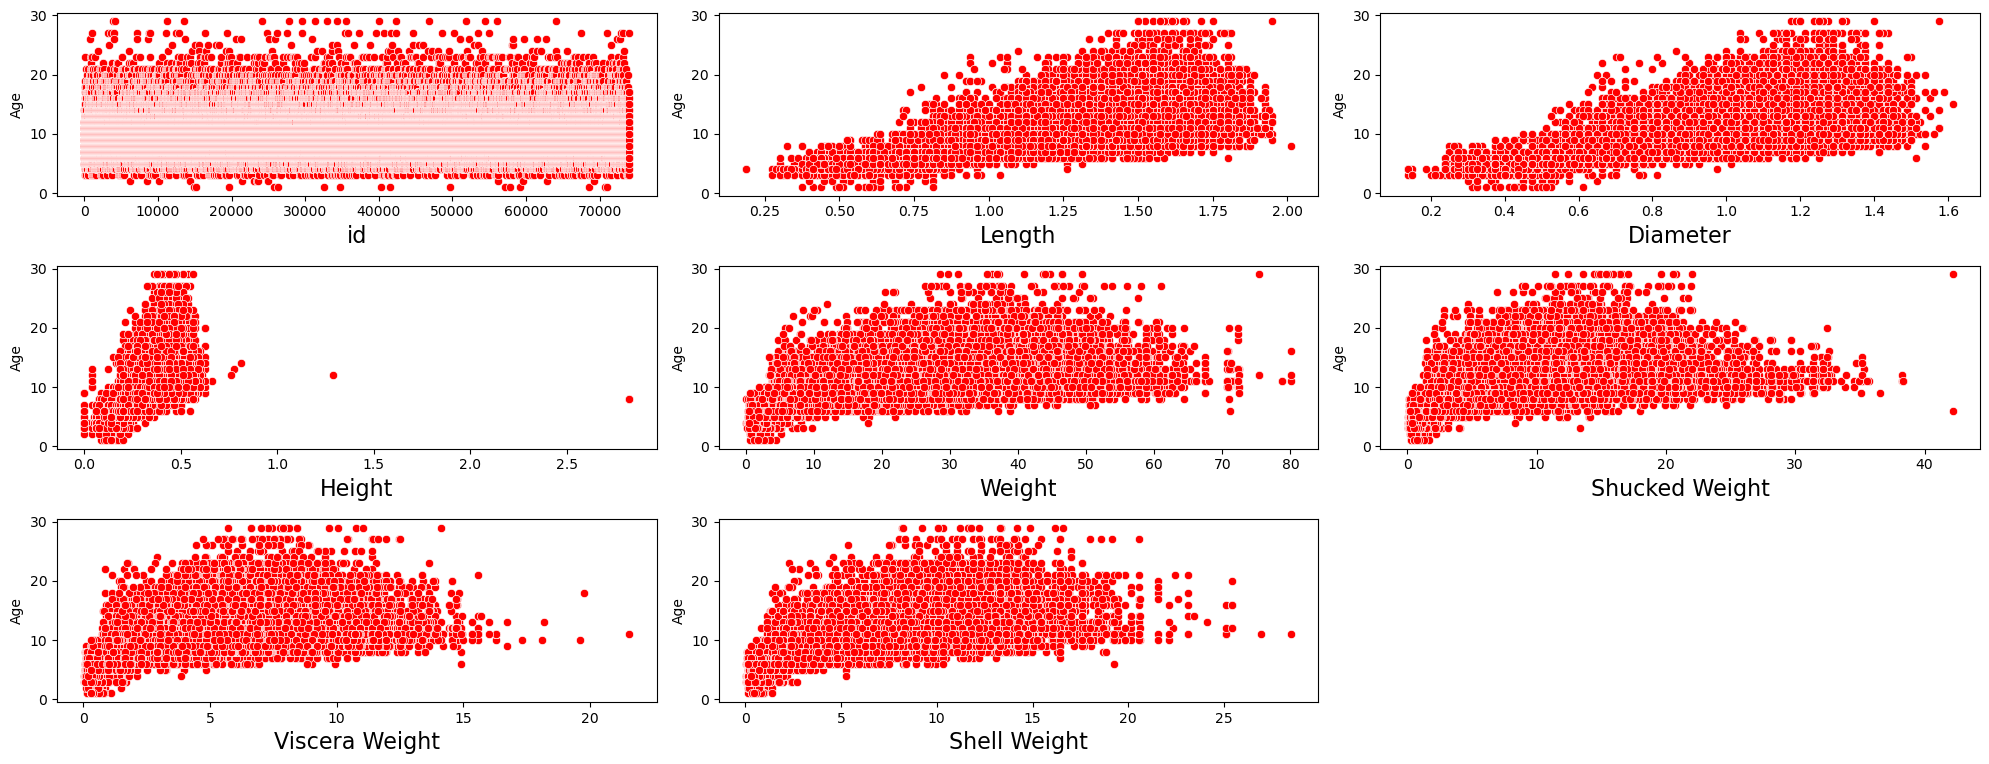

In [16]:
#Let's try some scatter for our numerical features

plot_grid(train,
          fig_size=(20,30), grid_size=(12,3), plot_type='scatterplot', target='Age')

/tmp/ipykernel_21/1052083072.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train.corr()


<Axes: >

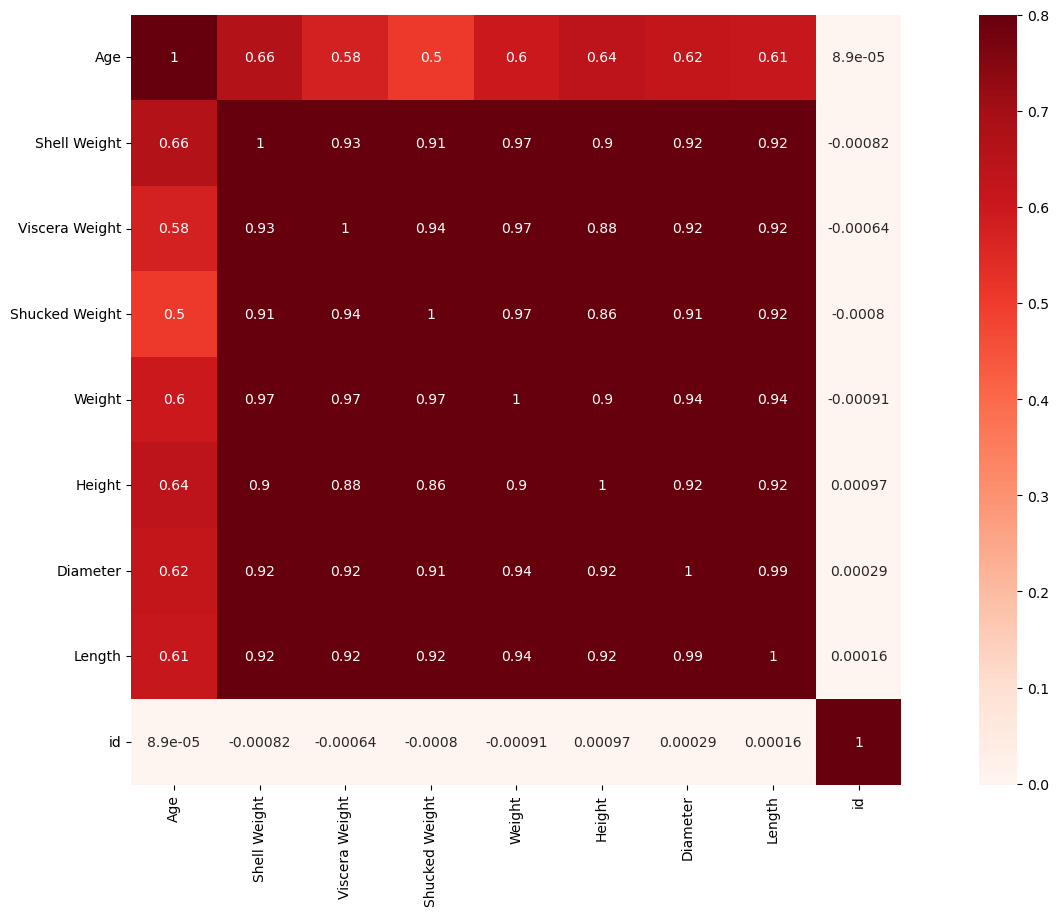

In [17]:
#Let's see the correlation matrix

correlation = train.corr()
plt.figure(figsize = (20,10))
sns.heatmap(correlation.loc[::-1,::-1], 
            square = True, 
            vmax = 0.8,
           cmap="Reds",
           annot=True)

Obervation : There is wierdly high correlation between these features.

## 2.3 Categorical Data

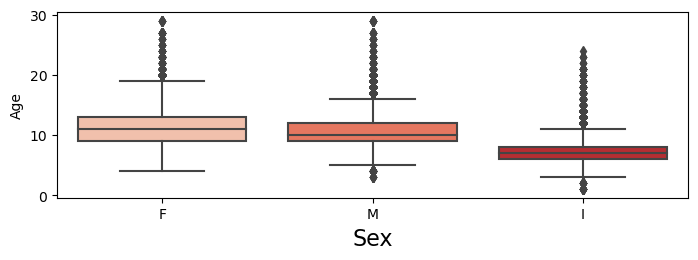

In [18]:
plot_grid(train,
          fig_size=(20,30), grid_size=(12,3), plot_type='boxplot_cat', target='Age')

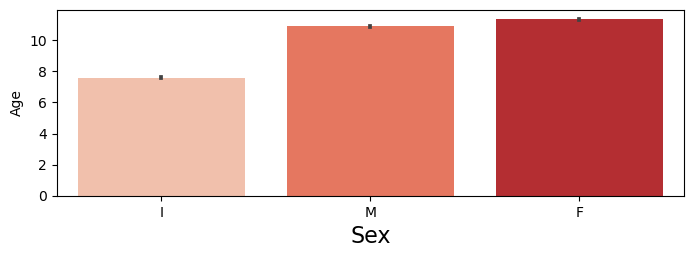

In [19]:
plot_grid(train,
          fig_size=(20,30), grid_size=(12,3), plot_type='barplot_cat', target='Age')

Obervations: 

There seems to be a lot of outliers, which we will deal in next section.

# 3. Data Cleaning and Feature Engineering

In [20]:
# Copy the train and test data before cleaning
target = train.Age
train_cleaning = train.drop('Age', axis = 1).copy()
test_cleaning = test.copy()

In [21]:
#Checking NULLS
train_cleaning.isnull().sum().max()

0

In [22]:
test_cleaning.isnull().sum().max()

0

### Dealing with NULLS and Outliers

In [23]:
#Height has more correlation with other numerical cols

"""temp = train_cleaning.copy()

X_temp_train=temp[temp.Height != 0 ]
y_temp_train = X_temp_train.Height
X_temp_train=X_temp_train.drop('Height',axis=1)

X_temp_val=temp[temp.Height == 0 ]
X_temp_val=X_temp_val.drop('Height',axis=1)

lr = LinearRegression()

lr.fit(X_temp_train,y_temp_train)

y_pred_val=lr.predict(X_temp_val)

X_temp_train['Height'] = y_temp_train
X_temp_val['Height'] = y_pred_val
new_test_cleaned = pd.concat([X_temp_train, X_temp_val],axis=0)
new_test_cleaned = new_test_cleaned.sort_values(by="id")

train_cleaning = new_test_cleaned"""

train_cleaning.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248


In [24]:
train_cleaning.loc[train_cleaning.Height==0, 'Height'] = train_cleaning.groupby("Sex")["Height"].transform("mean")
test_cleaning.loc[test_cleaning.Height==0, 'Height'] = test_cleaning.groupby("Sex")["Height"].transform("mean")

In [25]:
train_cleaning.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348175,23.385217,10.104270,5.058386,6.723870
std,21376.826729,0.287757,0.237396,0.091833,12.648153,5.618025,2.792729,3.584372
min,0.000000,0.187500,0.137500,0.012500,0.056699,0.028349,0.042524,0.042524
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248


In [26]:
test_cleaning.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348772,23.464627,10.130220,5.072615,6.745876
std,14251.458382,0.286950,0.236593,0.092082,12.641703,5.611779,2.791563,3.575650
min,74051.000000,0.187500,0.137500,0.025000,0.056699,0.028349,0.014175,0.042524
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


We might use these new features suggested by ChatGPT. Inspired by @phongnguyen1

Volume:
volume = π * (diameter/2)^2 * height

Density:
density = weight / volume

Shell-to-Body Ratio:
shell_to_body_ratio = shell_weight / (shucked_weight + viscera_weight)

Body-to-Shell Ratio:
body_to_shell_ratio = (shucked_weight + viscera_weight) / shell_weight

Weight Difference:
weight_difference = weight - (shucked_weight + viscera_weight)

Length-to-Diameter Ratio:
length_to_diameter_ratio = length / diameter

Weight-to-Size Ratio:
weight_to_size_ratio = weight / length

Surface Area:
surface_area = 2 * π * (diameter/2) * (diameter/2) + 2 * π * (diameter/2) * height

Carapace Index:
carapace_index = length / diameter

Meat-to-Shell Ratio:
meat_to_shell_ratio = (shucked_weight + viscera_weight) / shell_weight

Shell-to-Weight Ratio:
shell_to_weight_ratio = shell_weight / weight

Meat Density:
meat_density = (shucked_weight + viscera_weight) / (length * diameter * height)

Shell Density:
shell_density = shell_weight / (diameter * diameter * height)

In [27]:
#New features
import math 

train_cleaning['WeightToSizeRatio']=train_cleaning.Weight / train_cleaning.Length
train_cleaning['Volume'] = math.pi * (train_cleaning.Diameter/2)**2 * train_cleaning.Height
train_cleaning['LogDensity']=np.log(train_cleaning.Weight / train_cleaning.Volume)
#train_cleaning['LengthToDiameter'] = train_cleaning.Length / train_cleaning.Diameter
#train_cleaning['ShellToBodyRatio'] = train_cleaning['Shell Weight']/(train_cleaning['Shucked Weight']+train_cleaning['Viscera Weight'])
#train_cleaning['WeightDifference']=train_cleaning.Weight-(train_cleaning['Shucked Weight']+train_cleaning['Viscera Weight'])
train_cleaning['SurfaceArea'] = (2* math.pi * (train_cleaning.Diameter/2)**2) + ( 2 * math.pi * (train_cleaning.Diameter/2)* train_cleaning.Height)
#train_cleaning['CarapaceIndex'] = train_cleaning.Length/train_cleaning.Diameter
#train_cleaning['MeatDensity'] = (train_cleaning['Shucked Weight'] + train_cleaning['Viscera Weight'])/(train_cleaning.Diameter**2 * train_cleaning.Height)
#train_cleaning['ShellDensity'] = train_cleaning['Shell Weight'] / (train_cleaning.Diameter**2 * train_cleaning.Height)

new_cols=['WeightToSizeRatio',
          'Volume', 
          'LogDensity',
          #'LengthToDiameter',
          #'ShellToBodyRatio',
          #'WeightDifference',
          'SurfaceArea',
          #'CarapaceIndex',
          #'MeatDensity',
          #'ShellDensity'
           ]

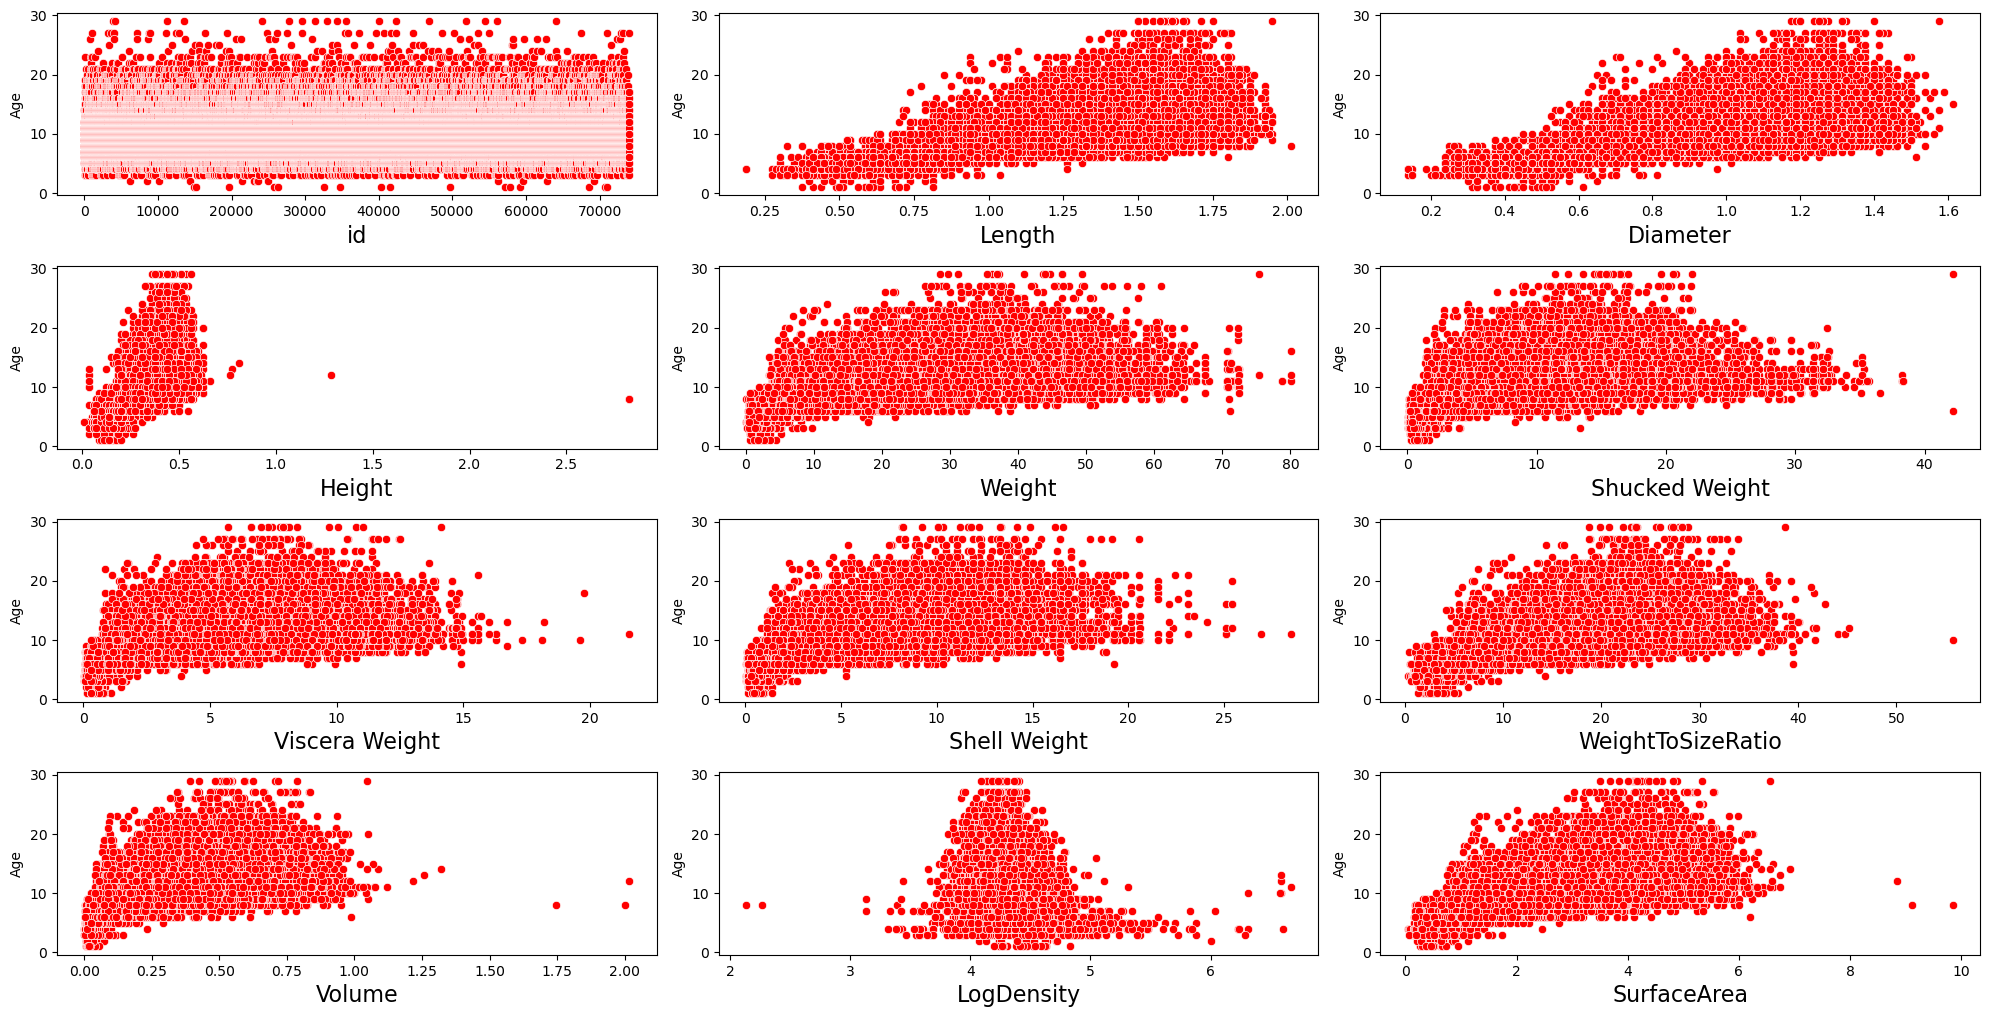

In [28]:
temp = pd.concat([train_cleaning,target],axis = 1)

plot_grid(temp,
          fig_size=(20,30), grid_size=(12,3), plot_type='scatterplot', target='Age')

In [29]:
def get_outliers(X_y, cols):
    """
    Custom function for dealing with outliers.
    It takes: DataFrame of data, list of columns;
    And it returns: list of unique indexes of outliers.(Also it outputs all outliers with indexes for each column)
    (value is considered an outlier if absolute value of its z-score is > 3)
    """
    outliers_index = []
    for col in cols:
        right_outliers = X_y[col][(X_y[col] - X_y[col].mean()) / X_y[col].std() > 5]
        left_outliers = X_y[col][(X_y[col] - X_y[col].mean()) / X_y[col].std() < -5]
        all_outliers = pd.concat([right_outliers,left_outliers],axis=1)
        outliers_index += (list(all_outliers.index))
        print('{} right outliers:\n\n{} \n{} left outliers:\n\n{} \n\n{} has TOTAL {} rows of outliers\n\n\n'.format(col, right_outliers, col, left_outliers, col, all_outliers.count()))
    outliers_index = list(set(outliers_index)) # Removing duplicates
    print('There are {} unique rows with outliers in dataset'.format(len(outliers_index)))
    return outliers_index

In [30]:
"""# Remove Outliers

outliers_index = get_outliers(train_cleaning, new_cols)

X_y = pd.concat([train_cleaning, target], axis = 1)
X_y = X_y.drop(outliers_index, axis = 0)

plot_grid(X_y,
          fig_size=(20,30), grid_size=(12,3), plot_type='scatterplot', target='Age')

train_cleaning = X_y.drop('Age', axis = 1).copy()
target = X_y.Age"""

"# Remove Outliers\n\noutliers_index = get_outliers(train_cleaning, new_cols)\n\nX_y = pd.concat([train_cleaning, target], axis = 1)\nX_y = X_y.drop(outliers_index, axis = 0)\n\nplot_grid(X_y,\n          fig_size=(20,30), grid_size=(12,3), plot_type='scatterplot', target='Age')\n\ntrain_cleaning = X_y.drop('Age', axis = 1).copy()\ntarget = X_y.Age"

In [31]:
train_cleaning.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,WeightToSizeRatio,Volume,LogDensity,SurfaceArea
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348175,23.385217,10.104270,5.058386,6.723870,16.374155,0.331831,4.283059,2.920922
std,21376.826729,0.287757,0.237396,0.091833,12.648153,5.618025,2.792729,3.584372,6.679701,0.187902,0.144398,1.196844
min,0.000000,0.187500,0.137500,0.012500,0.056699,0.028349,0.042524,0.042524,0.302395,0.000371,2.129376,0.040497
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,11.598643,0.182900,4.195523,2.061670
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,17.120087,0.332616,4.273543,3.066980
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,21.170830,0.466527,4.357237,3.817035
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,55.720664,2.017502,6.671286,9.848893


/tmp/ipykernel_21/2555931157.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_cleaning.corr()


<Axes: >

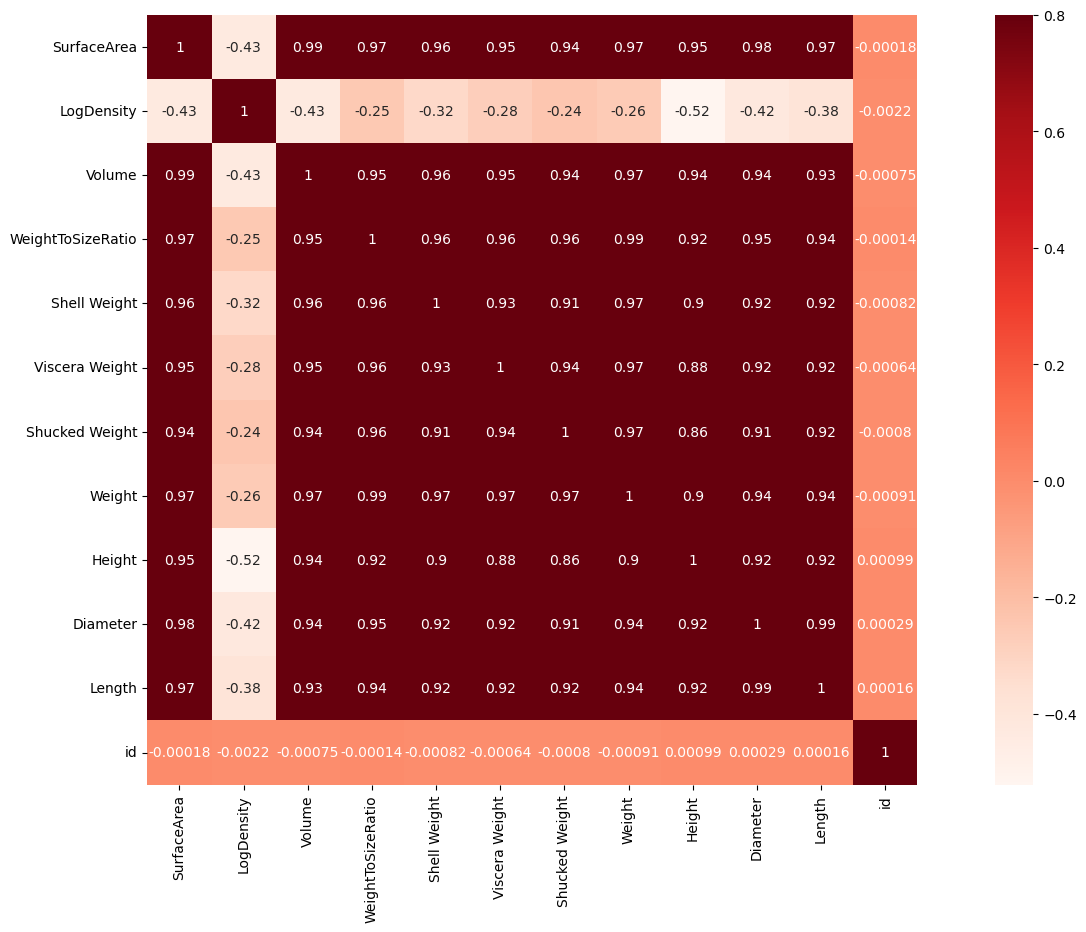

In [32]:
correlation = train_cleaning.corr()
plt.figure(figsize = (20,10))
sns.heatmap(correlation.loc[::-1,::-1], 
            square = True, 
            vmax = 0.8,
            cmap="Reds",
            annot=True,
           )

In [33]:
test_cleaning['WeightToSizeRatio']=test_cleaning.Weight / test_cleaning.Length
test_cleaning['Volume'] = math.pi * (test_cleaning.Diameter/2)**2 * test_cleaning.Height
test_cleaning['LogDensity']=np.log(test_cleaning.Weight / test_cleaning.Volume)
#test_cleaning['LengthToDiameter'] = test_cleaning.Length / test_cleaning.Diameter
#test_cleaning['ShellToBodyRatio'] = test_cleaning['Shell Weight']/(test_cleaning['Shucked Weight']+test_cleaning['Viscera Weight'])
#test_cleaning['WeightDifference']=test_cleaning.Weight-(test_cleaning['Shucked Weight']+test_cleaning['Viscera Weight'])
test_cleaning['SurfaceArea'] = (2* math.pi * 
                                (test_cleaning.Diameter/2)**2) + ( 2 * math.pi * (test_cleaning.Diameter/2)* test_cleaning.Height)
#test_cleaning['CarapaceIndex'] = test_cleaning.Length/train_cleaning.Diameter
#test_cleaning['MeatDensity'] = (test_cleaning['Shucked Weight'] + test_cleaning['Viscera Weight'])/(test_cleaning.Diameter**2 * test_cleaning.Height)
#test_cleaning['ShellDensity'] = test_cleaning['Shell Weight'] / (test_cleaning.Diameter**2 * test_cleaning.Height)


In [34]:
#Double checking for BAD values ( like INF or NAN)

test_cleaning.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,WeightToSizeRatio,Volume,LogDensity,SurfaceArea
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348772,23.464627,10.130220,5.072615,6.745876,16.411763,0.333171,4.282627,2.929966
std,14251.458382,0.286950,0.236593,0.092082,12.641703,5.611779,2.791563,3.575650,6.665061,0.187768,0.146790,1.194633
min,74051.000000,0.187500,0.137500,0.025000,0.056699,0.028349,0.014175,0.042524,0.206178,0.000371,2.016212,0.040497
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930,11.656827,0.185587,4.194276,2.073697
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627,17.127831,0.335482,4.272749,3.081706
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063,21.212626,0.466527,4.356455,3.832988
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,45.127613,2.199992,6.785683,9.383545


# 4. Data Normalisation and One-hot encoding

In [35]:
num_cols=train_cleaning.select_dtypes(exclude=object).columns

In [36]:
fig, axes = plt.subplots(len(num_cols),2, figsize=(60,100))
for i, col in enumerate(num_cols):
    sns.histplot(data=train_cleaning, x=col, ax=axes[i, 0], bins=20, color="red")
    sns.histplot(data=np.log1p(train_cleaning[[col]]), x=col, ax=axes[i, 1], color="orange")
    axes[i, 0].set_title('Normal Distribution')
    axes[i, 1].set_title('Logarithmic Distribution')
plt.tight_layout()

In [37]:
#Normalised Data looks better. Let's do for train and test

for col in num_cols:
    train_cleaning[col] = np.log1p(train_cleaning[col])
    test_cleaning[col] = np.log1p(test_cleaning[col])

In [38]:
test_train_cleaned=pd.concat([train_cleaning,test_cleaning],axis=0, keys=['train','test'])

In [39]:
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

def cat_encoder(X, cat_cols,encode='label'):
    
    if encode == 'label':
        ## Label Encoder
        encoder = OrdinalEncoder(cols=cat_cols, handle_missing='ignore')
        train_test_encoder = encoder.fit_transform(X[cat_cols]).astype(int)
        X[cat_cols] = train_test_encoder[cat_cols]
        encoder_cols = cat_cols
    
    else:
        ## OneHot Encoder
        encoder = OneHotEncoder(cols=cat_cols)
        train_test_encoder = encoder.fit_transform(X[cat_cols]).astype(int)
        X = pd.concat([X, train_test_encoder], axis=1)
        X.drop(cat_cols, axis=1, inplace=True)
        encoder_cols = list(train_test_encoder.columns)
        
    return X,encoder_cols

In [40]:
# Label encoding for categoricals
"""for colname in test_train_cleaned.select_dtypes("object"):
    test_train_cleaned[colname], _ = test_train_cleaned[colname].factorize()"""
cat_cols = ['Sex']

test_train_cleaned, cat_cols = cat_encoder(test_train_cleaned, cat_cols, encode='ohe')

In [41]:
test_train_cleaned.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,WeightToSizeRatio,Volume,LogDensity,SurfaceArea,Sex_1,Sex_2,Sex_3
count,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000,123419.000000
mean,10.723395,0.832402,0.698215,0.296572,3.002975,2.240224,1.672023,1.909037,2.757718,0.277043,1.664101,1.311451,0.323451,0.364668,0.311881
std,0.999685,0.133648,0.125141,0.069040,0.708052,0.642377,0.549357,0.569466,0.487882,0.140932,0.027160,0.353235,0.467795,0.481339,0.463263
min,0.000000,0.171850,0.128833,0.012423,0.055150,0.027955,0.014075,0.041645,0.187457,0.000371,1.104002,0.039699,0.000000,0.000000,0.000000
25%,10.337070,0.765468,0.635253,0.262364,2.674737,1.908175,1.355184,1.603205,2.535780,0.169575,1.647688,1.122881,0.000000,0.000000,0.000000
50%,11.030201,0.864997,0.729961,0.309321,3.210820,2.389510,1.790010,2.072622,2.897187,0.287144,1.662649,1.406094,0.000000,0.000000,0.000000
75%,11.435661,0.931179,0.788457,0.345361,3.502701,2.711190,2.079732,2.312554,3.099750,0.382897,1.678410,1.572159,1.000000,1.000000,1.000000
max,11.723340,1.111035,0.965081,1.341558,4.395702,3.765471,3.115541,3.384094,4.038139,1.163148,2.052287,2.384063,1.000000,1.000000,1.000000


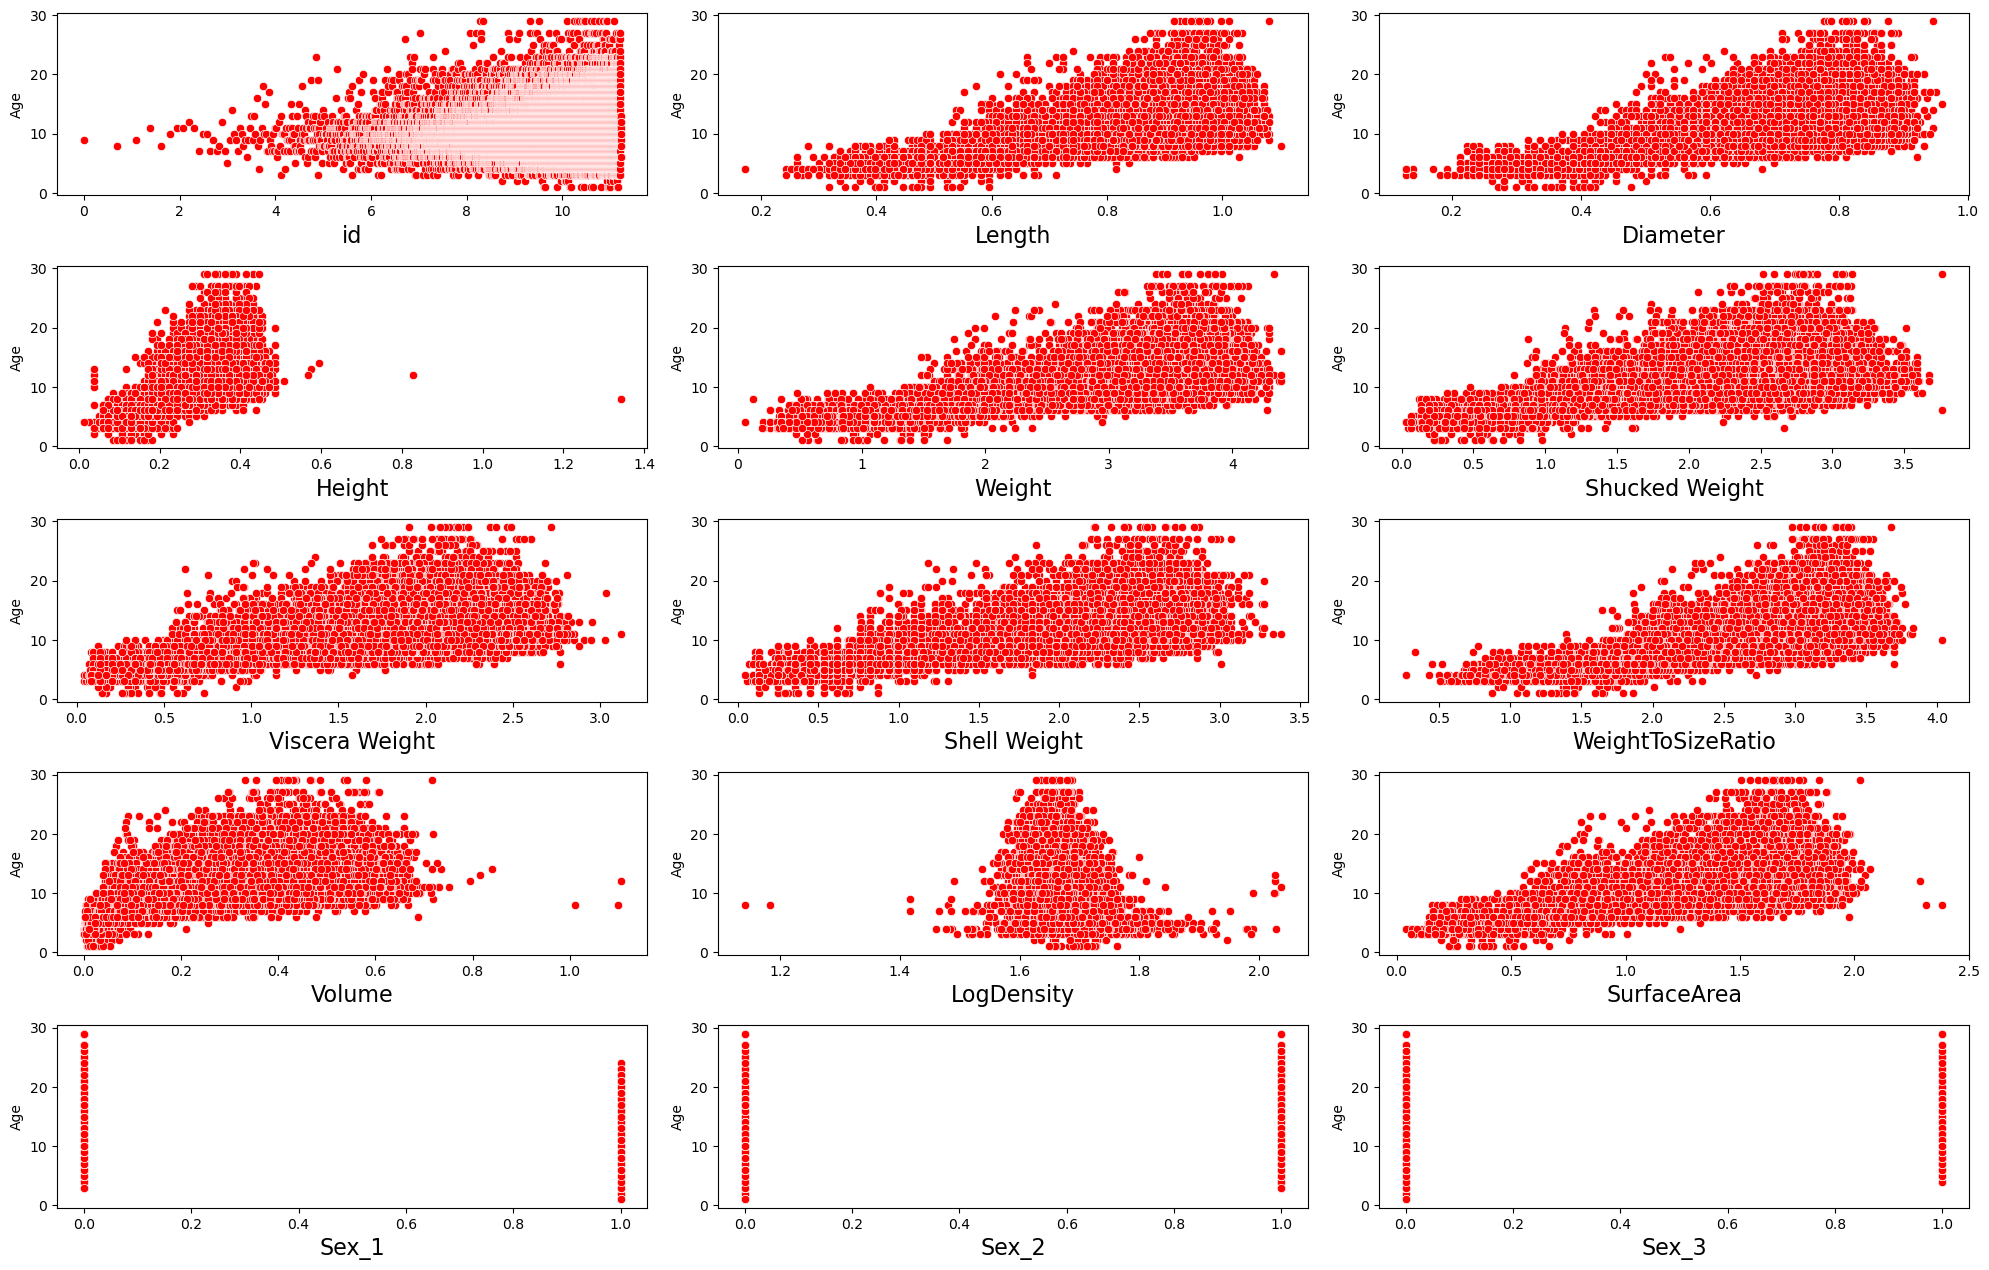

In [42]:
temp = pd.concat([test_train_cleaned.xs('train'),target],axis = 1)

plot_grid(temp,
          fig_size=(20,30), grid_size=(12,3), plot_type='scatterplot', target='Age')

In [43]:
#Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15)
test_train_cleaned["Cluster"] = kmeans.fit_predict(test_train_cleaned)
test_train_cleaned["Cluster"] = test_train_cleaned["Cluster"].astype("object")

train.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


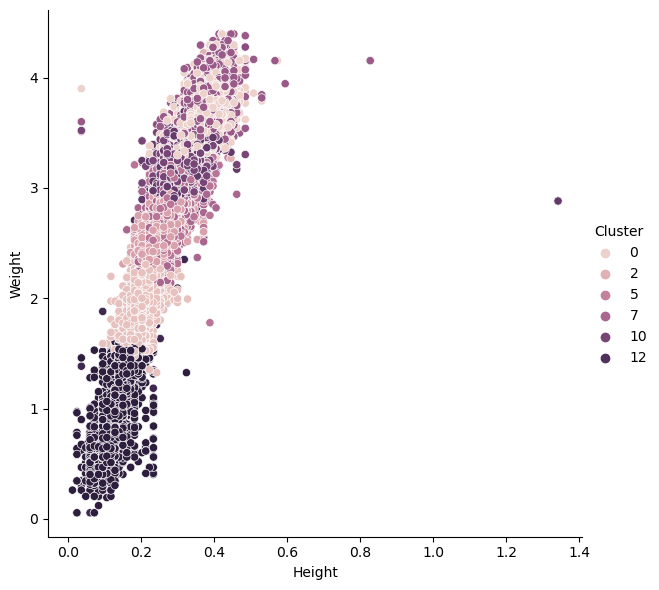

In [44]:
sns.relplot(
    x="Height", y="Weight", hue="Cluster", data=test_train_cleaned, height=6,
);

In [45]:
# We can drop Id
test_train_cleaned.drop('id',axis=1,inplace=True)
#test_train_cleaned.drop('Diameter',axis=1,inplace=True)

In [46]:
train_test = pd.get_dummies(test_train_cleaned)

print("These are our final list of features")
print(train_test.columns)

These are our final list of features
Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'WeightToSizeRatio', 'Volume',
       'LogDensity', 'SurfaceArea', 'Sex_1', 'Sex_2', 'Sex_3', 'Cluster_0',
       'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5',
       'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9', 'Cluster_10',
       'Cluster_11', 'Cluster_12', 'Cluster_13', 'Cluster_14'],
      dtype='object')


/tmp/ipykernel_21/3021571530.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  train_test = pd.get_dummies(test_train_cleaned)


In [47]:
X_train_full, X_test = train_test.xs('train'), train_test.xs('test')
y_train_full=target.copy()

In [48]:
X_train_full.isnull().sum()

Length               0
Diameter             0
Height               0
Weight               0
Shucked Weight       0
Viscera Weight       0
Shell Weight         0
WeightToSizeRatio    0
Volume               0
LogDensity           0
SurfaceArea          0
Sex_1                0
Sex_2                0
Sex_3                0
Cluster_0            0
Cluster_1            0
Cluster_2            0
Cluster_3            0
Cluster_4            0
Cluster_5            0
Cluster_6            0
Cluster_7            0
Cluster_8            0
Cluster_9            0
Cluster_10           0
Cluster_11           0
Cluster_12           0
Cluster_13           0
Cluster_14           0
dtype: int64

# 5. Model Building

## 5.1 Baseline Validation

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=0)


In [50]:
model_table = pd.DataFrame(columns = ['Model Name', 'MAE'])
def model_accuracy(model,model_name):
    #score = cross_val_score(model,X_train, y_train, cv=5)
    
     # Train the model
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    
    i=len(model_table)
    model_table.loc[i,'Model Name']=model_name
    model_table.loc[i,'MAE']=mae

In [51]:
models = [
    ('linear', LinearRegression()),
    ('ridgecv', RidgeCV(alphas=np.logspace(-6, 6, 13))),
    ('knn',KNeighborsRegressor()),
    ('rf',RandomForestRegressor()),
    ('lgb',LGBMRegressor(random_state = seed, objective = 'mae')),
    ('dart', LGBMRegressor(random_state = seed, boosting_type = 'dart')),
    ('cat',CatBoostRegressor(verbose=False)),
    ('huber', HuberRegressor(max_iter = 1000000)),
    ('ard',ARDRegression()),
    ('hgb',HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('gb',GradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('xgb', XGBRegressor(random_state = seed,objective='reg:absoluteerror')), 
    #('theilsen', TheilSenRegressor(random_state = seed)),
    #('ada',AdaBoostClassifier(random_state = seed))
    #('elastic',ElasticNet(random_state = seed, max_iter = 1000000)),
    #('lasso', Lasso(random_state = seed, max_iter = 1000000)),
    #('passive', PassiveAggressiveRegressor(random_state = seed)),
    #('linearsvm', LinearSVR(random_state = seed, max_iter = 1000000)),
    #('mlp', MLPRegressor(random_state = seed, max_iter = 1000000)),
    #('et', ExtraTreesRegressor(random_state = seed, criterion = 'absolute_error')),
    #('rf', RandomForestRegressor(random_state = seed, criterion = 'absolute_error')),
    #('dt',tree.DecisionTreeRegressor()),
]

for (label, model) in models:
    model_accuracy(model, label)
    
display(model_table.sort_values(by='MAE').style.background_gradient(cmap='summer_r'))

print("Baseline Validation done!")

# 1.358201
# 1.355153

,Model Name,MAE
4,lgb,1.356312
9,hgb,1.358755
11,xgb,1.368157
6,cat,1.402606
10,gb,1.424134
7,huber,1.447318
3,rf,1.464441
5,dart,1.488249
8,ard,1.496719
0,linear,1.496830


Baseline Validation done!


<Axes: xlabel='MAE', ylabel='Model Name'>

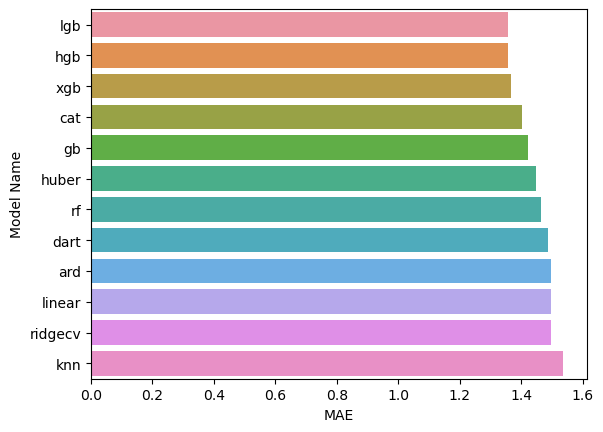

In [52]:
#Let's also plot it

model_table=model_table.sort_values(by='MAE')

sns.barplot(data=model_table, x="MAE", y="Model Name",)

In [53]:
def postprocessor(prediction):
    #thanks to @mattop
    unique_targets = np.unique(train['Age'])
    return [min(unique_targets, key = lambda x: abs(x - pred)) for pred in prediction]

In [54]:
rounded_model_table = pd.DataFrame(columns = ['Model Name', 'Train MAE', 'Test MAE'])
def rounded_accuracy(model,model_name):
    
     # Train the model
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_hat = postprocessor(model.predict(X_train))
    y_pred = postprocessor(model.predict(X_valid))
    train_mae = mean_absolute_error(y_train, y_hat)
    test_mae = mean_absolute_error(y_valid, y_pred)
    
    i=len(rounded_model_table)
    rounded_model_table.loc[i,'Model Name']=model_name
    rounded_model_table.loc[i,'Train MAE']=train_mae
    rounded_model_table.loc[i,'Test MAE']=test_mae
    
for (label, model) in models:
    rounded_accuracy(model, label)
    
display(rounded_model_table.sort_values(by='Test MAE').style.background_gradient(cmap='summer_r'))

print("Rounded Baseline Validation!")

,Model Name,Train MAE,Test MAE
4,lgb,1.337036,1.340895
9,hgb,1.336816,1.343663
11,xgb,1.290007,1.343663
6,cat,1.280554,1.375802
10,gb,1.411124,1.411451
7,huber,1.427397,1.417730
3,rf,0.465260,1.447168
5,dart,1.457596,1.461616
0,linear,1.475540,1.472082
8,ard,1.475895,1.472149


Rounded Baseline Validation!


## 5.1 Parameter Tuning

In [55]:
"""import optuna
import sklearn
from sklearn import datasets
def objective(trial):
    param = {
    "learning_rate": trial.suggest_float('learning_rate',0.001,0.5),
    "min_samples_leaf" :trial.suggest_int('min_samples_leaf',5,72),
    "max_bins": trial.suggest_int('max_bins',20,255),
    "l2_regularization": trial.suggest_int('l2_regularization',0.001,0.02),
    "early_stopping": True,
    "max_depth": trial.suggest_int('max_depth',10,22),
    "max_leaf_nodes": trial.suggest_int('max_leaf_nodes',10,70)
    }
    
    # Train the HGB regressor
    model = HistGradientBoostingRegressor(**param)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    return mae

study_hist=optuna.create_study(direction="minimize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_hist.optimize(objective,n_trials=1000)

# Print the best parameters and the best MAE
hist_best_params = study_hist.best_params
hist_best_mae = study_hist.best_value
print(f"Best Parameters: {hist_best_params}")
print(f"Best MAE: {hist_best_mae}")"""

'import optuna\nimport sklearn\nfrom sklearn import datasets\ndef objective(trial):\n    param = {\n    "learning_rate": trial.suggest_float(\'learning_rate\',0.001,0.5),\n    "min_samples_leaf" :trial.suggest_int(\'min_samples_leaf\',5,72),\n    "max_bins": trial.suggest_int(\'max_bins\',20,255),\n    "l2_regularization": trial.suggest_int(\'l2_regularization\',0.001,0.02),\n    "early_stopping": True,\n    "max_depth": trial.suggest_int(\'max_depth\',10,22),\n    "max_leaf_nodes": trial.suggest_int(\'max_leaf_nodes\',10,70)\n    }\n    \n    # Train the HGB regressor\n    model = HistGradientBoostingRegressor(**param)\n    model.fit(X_train, y_train)\n\n    # Predict on the validation set and calculate MAE\n    y_pred = model.predict(X_valid)\n    mae = mean_absolute_error(y_valid, y_pred)\n\n    return mae\n\nstudy_hist=optuna.create_study(direction="minimize")\noptuna.logging.set_verbosity(optuna.logging.WARNING)\nstudy_hist.optimize(objective,n_trials=1000)\n\n# Print the best par

# 5.2 Model Stacking And Training

In [56]:
ensemble_models = [
    ('cat', CatBoostRegressor(random_state = seed, objective = 'MAE', verbose = 0)),
    ('hgb', HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('lgb', LGBMRegressor(random_state = seed, objective = 'mae')),
    ('xgb', XGBRegressor(random_state = seed, objective='reg:absoluteerror'))
]

model = VotingRegressor(ensemble_models)

rounded_accuracy(model, 'Voting Regressor')

In [57]:
rounded_model_table

#Train - 1.315277 Test - 1.335764
#Train - 1.314838 Test - 1.334279

,Model Name,Train MAE,Test MAE
0,linear,1.47554,1.472082
1,ridgecv,1.47581,1.472352
2,knn,1.236124,1.519884
3,rf,0.46526,1.447168
4,lgb,1.337036,1.340895
5,dart,1.457596,1.461616
6,cat,1.280554,1.375802
7,huber,1.427397,1.41773
8,ard,1.475895,1.472149
9,hgb,1.336816,1.343663


In [58]:
model.fit(X_train_full,y_train_full)

VotingRegressor(estimators=[('cat',
                             <catboost.core.CatBoostRegressor object at 0x79055841e1a0>),
                            ('hgb',
                             HistGradientBoostingRegressor(loss='absolute_error')),
                            ('lgb', LGBMRegressor(objective='mae')),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,...
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:absoluteerror',
                                          predictor=None, ...))])

# 5.3 Final Predictions and Submission

In [59]:
preds=postprocessor(model.predict(X_test))

In [60]:
basic_submission_val={'id':test.id,'Age':preds}
base_submssion = pd.DataFrame(data=basic_submission_val)
base_submssion.to_csv('submission.csv',index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


Did you find this notebook useful?

Please let me know how I can improve upon this. :)